## Imports

In [17]:
#General
import os
import warnings

#Data handling
import pandas as pd
import numpy as np

#Train test data splits
from sklearn.model_selection import train_test_split

#Hyperparameter support
from hyperparameters import parameters

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

#Performance measures
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score

#Visualize the results
from boxplot import plot_measure

#Result storage
import pickle

## Load data

In [18]:
DATA_FOLDER = "data"
#
PROCESS = False

In [19]:
if PROCESS:
    DATASETS = [
        "BroadleafCommerce-broadleaf-3.0.10-GA-Unified",
        "hazelcast-3.3-EA-Unified",
        "JUnit-Unified",
        "titan-0.5.1-Unified"
    ]
else:
    DATASETS = [
        "ant-1.7",
        "camel-1.6",
        "ivy-2.0",
        "jedit-3.2",
        "lucene-2.4",
        "poi-1.5",
        "synapse-1.2",
        "velocity-1.6"
    ]

In [20]:
datasets = dict()
for dataset in DATASETS:
    if PROCESS:
        dataset_file = os.path.join(DATA_FOLDER, dataset) + ".csv"
        df = pd.read_csv(dataset_file)
        df = df.drop(['ID','Name','LongName','Parent','LongName.1','Parent.1', 'McCC.1', 'CLOC.1',  'LLOC.1', 'ID.1', 'Name.1'], axis=1)
    else:
        dataset_file = os.path.join(DATA_FOLDER, dataset) + ".csv"
        df = pd.read_csv(dataset_file)
        df = df.drop(['name','version','name.1'], axis=1)
    #
    df.loc[df['bug'] > 0, 'bug'] = 1
    #
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    #
    X = df.drop(['bug'], axis=1)
    Y = df["bug"]
    #
    share = round(len(Y[Y>0])/len(Y),4)
    #
    datasets[dataset] = {
        "X": X,
        "Y": Y, 
        "Share": share
    }
    #
    if PROCESS:
        print("{:45s}  Count: {:3d}  Defective: {:3d}  Share: {:1.4f}".format(dataset, len(X), len(Y[Y>0]), share))
    else:
        print("{:12s}  Count: {:3d}  Defective: {:3d}  Share: {:1.4f}".format(dataset, len(X), len(Y[Y>0]), share))

ant-1.7       Count: 745  Defective: 166  Share: 0.2228
camel-1.6     Count: 965  Defective: 188  Share: 0.1948
ivy-2.0       Count: 352  Defective:  40  Share: 0.1136
jedit-3.2     Count: 272  Defective:  90  Share: 0.3309
lucene-2.4    Count: 340  Defective: 203  Share: 0.5971
poi-1.5       Count: 237  Defective: 141  Share: 0.5949
synapse-1.2   Count: 256  Defective:  86  Share: 0.3359
velocity-1.6  Count: 229  Defective:  78  Share: 0.3406


## Run experiment

In [21]:
REPEAT_FACTOR = 30
PRINT_STEP = 5

In [22]:
MODELS = [LogisticRegression, GaussianNB, DecisionTreeClassifier, KNeighborsClassifier, RandomForestClassifier]

In [23]:
warnings.filterwarnings("ignore")

In [ ]:
if PROCESS:
    TEST_SIZE = 0.3
else:
    TEST_SIZE = 0.2

In [30]:
data = []
for dataset in DATASETS:
    print("Analyzing {:12s}".format(dataset))
    for i in range(REPEAT_FACTOR):
        if i%PRINT_STEP ==0:
            print("Step: {:3d}".format((i)))
        X = datasets[dataset]["X"]
        Y = datasets[dataset]["Y"]
        #
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=TEST_SIZE)
        #
        train_min = X_train.min()
        train_dim = X_train.max() - X_train.min()
        train_dim[train_dim == 0] = 1
        #
        X_train = (X_train - train_min) / train_dim
        X_test = (X_test - train_min) / train_dim
        #
        X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
        X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)        
        #
        for model_provider in MODELS:
            for config_id, kwargs in enumerate(parameters[model_provider.__name__]):
                try:
                    model = model_provider(**kwargs)
                    #
                    model.fit(X_train, y_train)
                    #
                    y_p = model.predict(X_test)
                    #
                    f1 = f1_score(y_test, y_p)
                    precision = precision_score(y_test, y_p)
                    recall = recall_score(y_test, y_p)
                    mcc =  matthews_corrcoef(y_test, y_p)
                    accuracy = accuracy_score(y_test, y_p)
                    #
                    data.append([dataset, model_provider.__name__, f1, precision, recall, mcc, accuracy, config_id])
                except Exception as e:
                    print("ERROR: " + str(e))
        #
    print()

Analyzing ant-1.7     
Step:   0
Step:   5

Analyzing camel-1.6   
Step:   0
Step:   5

Analyzing ivy-2.0     
Step:   0
Step:   5

Analyzing jedit-3.2   
Step:   0
Step:   5

Analyzing lucene-2.4  
Step:   0
Step:   5

Analyzing poi-1.5     
Step:   0
Step:   5

Analyzing synapse-1.2 
Step:   0
Step:   5

Analyzing velocity-1.6
Step:   0
Step:   5



In [31]:
df = pd.DataFrame(data, columns = ["Dataset", "Model","F1", "Precision", "Recall", "MCC", "Accuracy", "Config"])

In [32]:
best = {}
for dataset in DATASETS:
    for model in MODELS:
        dm_df = df[(df["Dataset"]==dataset) & (df["Model"]==model.__name__)]
        means = dm_df.groupby(["Config"])[["F1","Precision","Recall"]].mean()
        max_f1 = means["F1"].max()
        best_configs = means[means["F1"]==max_f1]
        best_config_id = best_configs.index[0] #Get index of one of the best configs
        best[(dataset,model.__name__)] = best_config_id

In [33]:
acc_mean_best = None
for dataset in DATASETS:
    for model in MODELS:
        dm_df = df[(df["Dataset"]==dataset) & (df["Model"]==model.__name__) & (df["Config"]==best[(dataset,model.__name__)])]
        mean_best = dm_df.groupby(["Dataset", "Model"]).mean()
        if acc_mean_best is None:
            acc_mean_best = mean_best
        else:
            acc_mean_best = acc_mean_best.append(mean_best)
print(acc_mean_best)

                                           F1  Precision    Recall       MCC  \
Dataset      Model                                                             
ant-1.7      LogisticRegression      0.235357   0.930714  0.138755  0.302271   
             GaussianNB              0.586434   0.629255  0.551880  0.477018   
             DecisionTreeClassifier  0.476161   0.470841  0.486415  0.319211   
             KNeighborsClassifier    0.073783   0.666667  0.039508  0.126155   
             RandomForestClassifier  0.121156   0.832143  0.067108  0.184448   
camel-1.6    LogisticRegression      0.019237   0.350000  0.009914  0.049408   
             GaussianNB              0.318042   0.495396  0.238242  0.237746   
             DecisionTreeClassifier  0.316478   0.310987  0.333288  0.140983   
             KNeighborsClassifier    0.004444   0.100000  0.002273  0.005975   
             RandomForestClassifier  0.045515   0.583333  0.023872  0.085514   
ivy-2.0      LogisticRegression      0.0

In [12]:
acc_mean_best = None
for dataset in DATASETS:
    for model in MODELS:
        dm_df = df[(df["Dataset"]==dataset) & (df["Model"]==model.__name__) & (df["Config"]==best[(dataset,model.__name__)])]
        if acc_mean_best is None:
            acc_mean_best = dm_df
        else:
            acc_mean_best = acc_mean_best.append(dm_df)
df = acc_mean_best

In [13]:
if PROCESS:
    df.to_pickle("result_objects/wp-pm-df.pkl")
    pickle.dump( best, open( "result_objects/best-pm-config.pkl", "wb" ) )
else:
    df.to_pickle("result_objects/wp-df.pkl")    
    pickle.dump( best, open( "result_objects/best-config.pkl", "wb" ) )

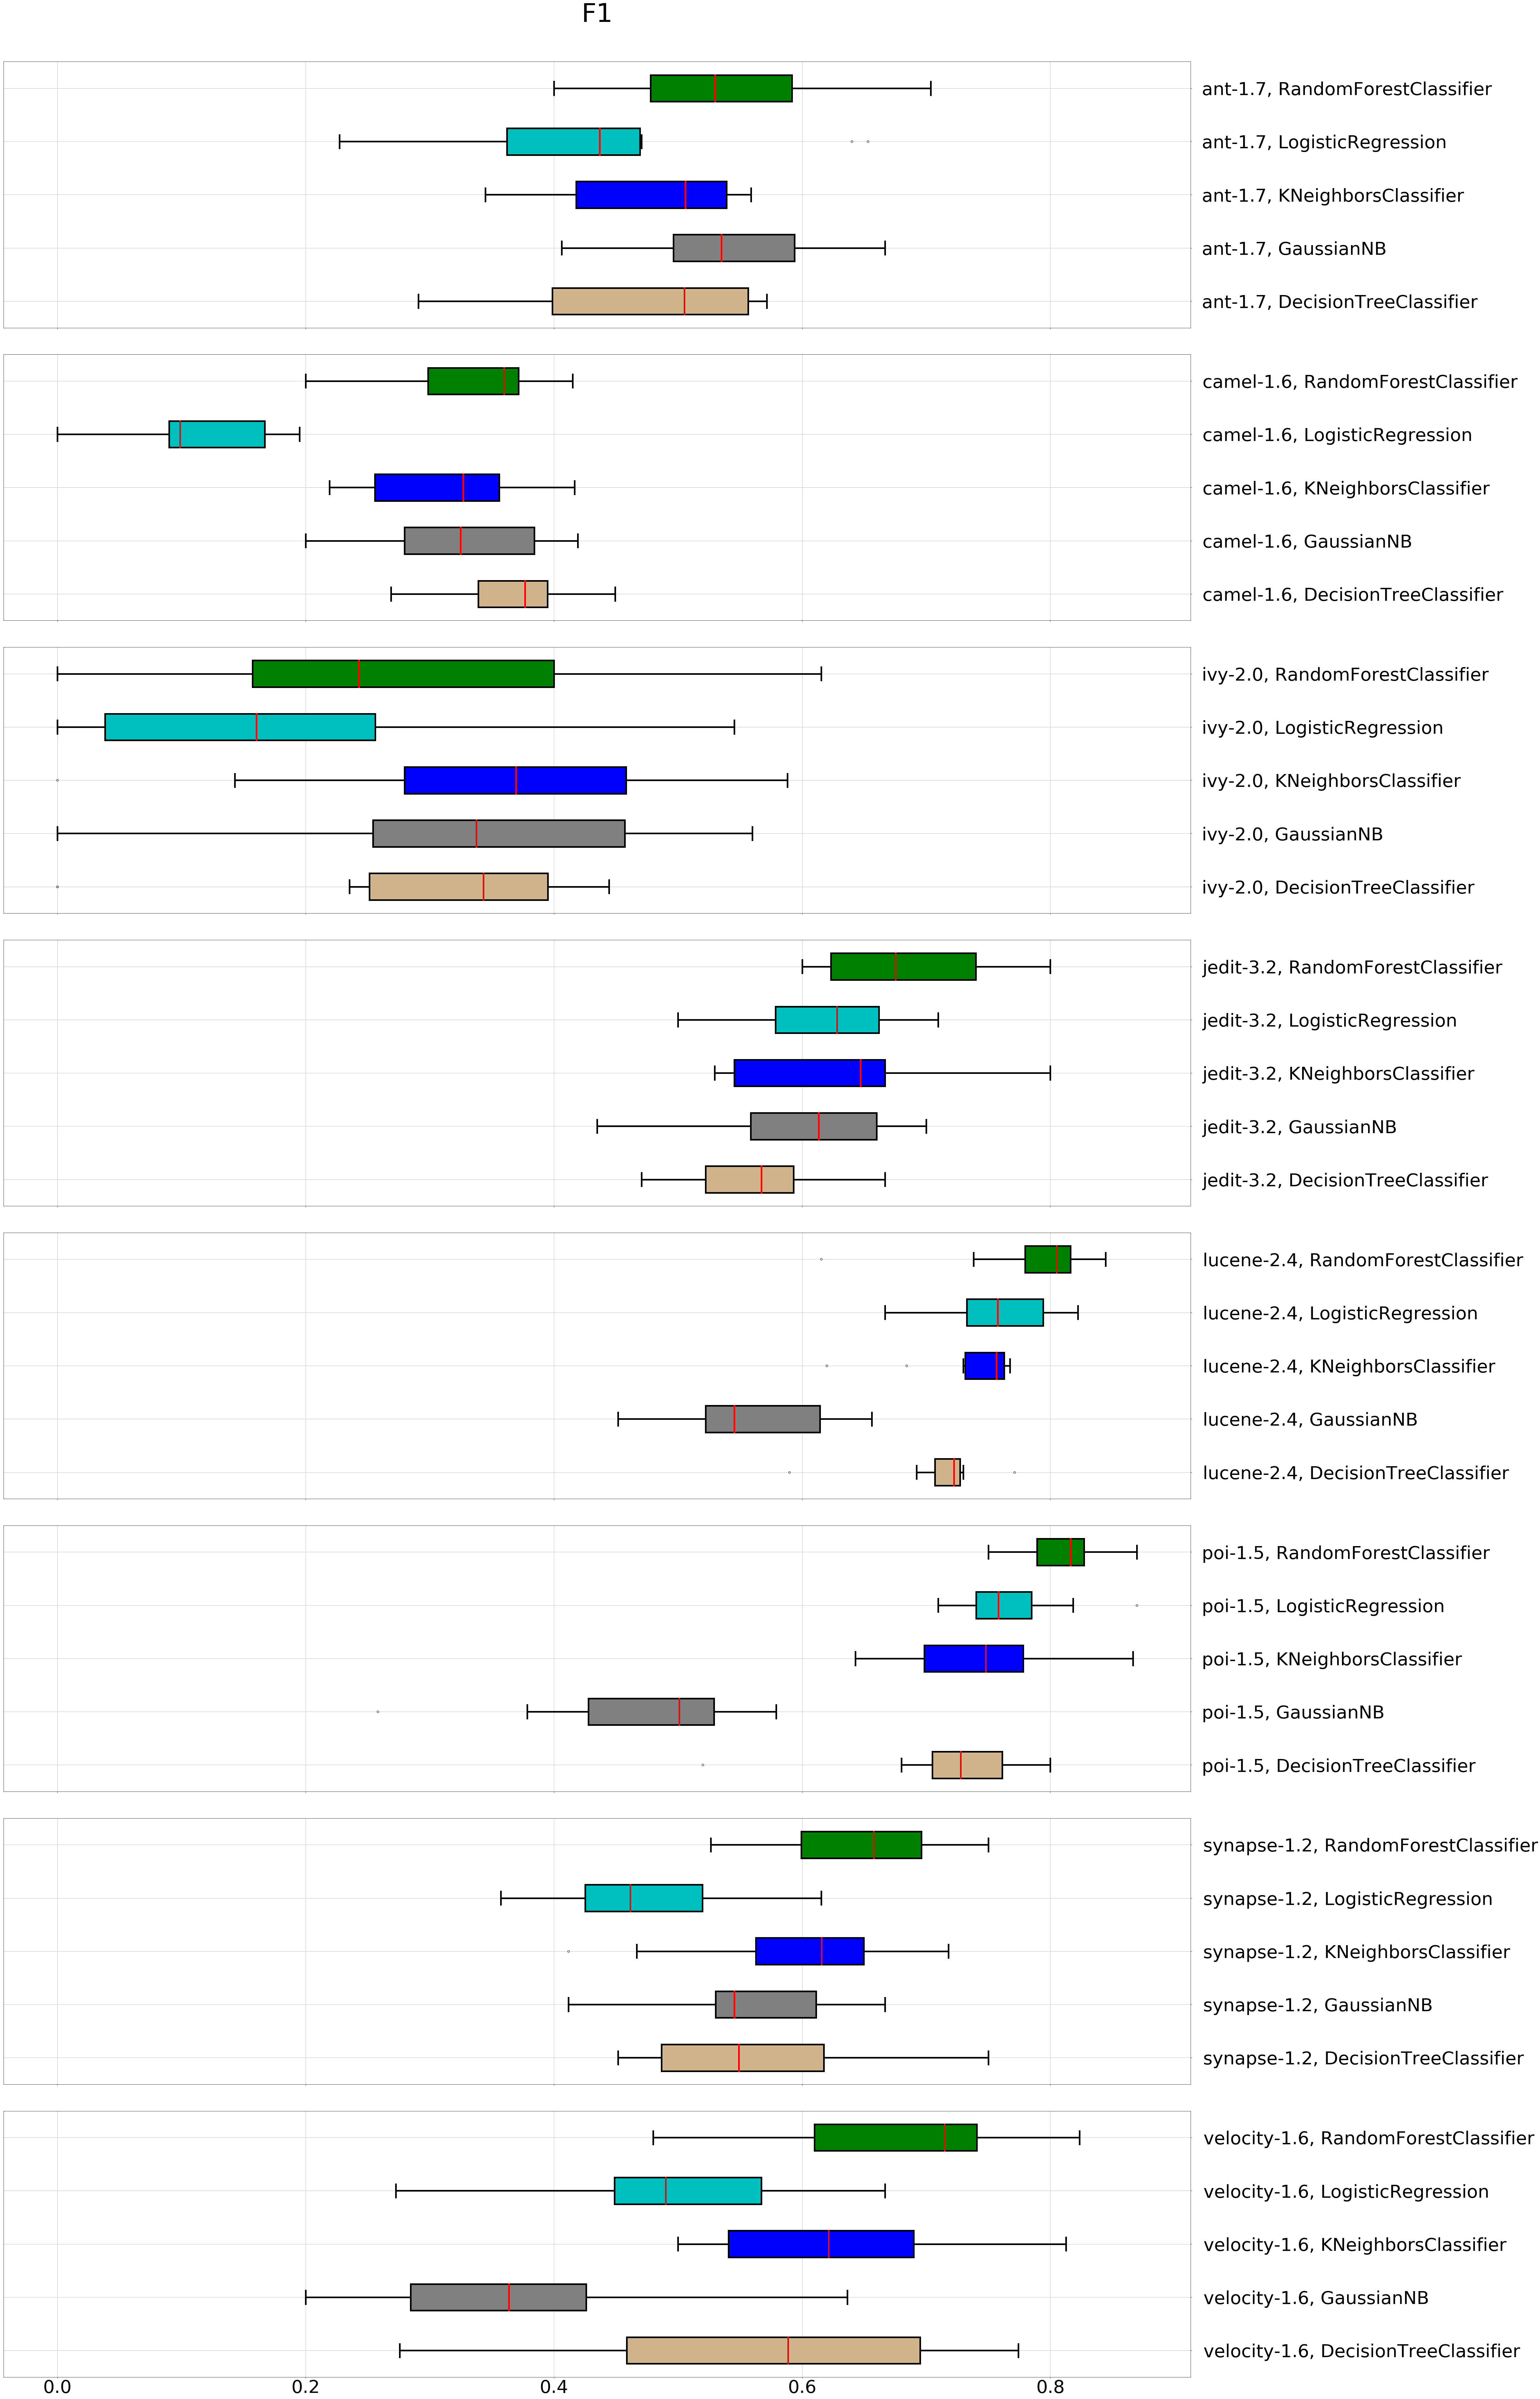

In [14]:
if PROCESS:
    plot_measure(df, "F1", "wp-pm-f1")
else:
    plot_measure(df, "F1", "wp-f1")

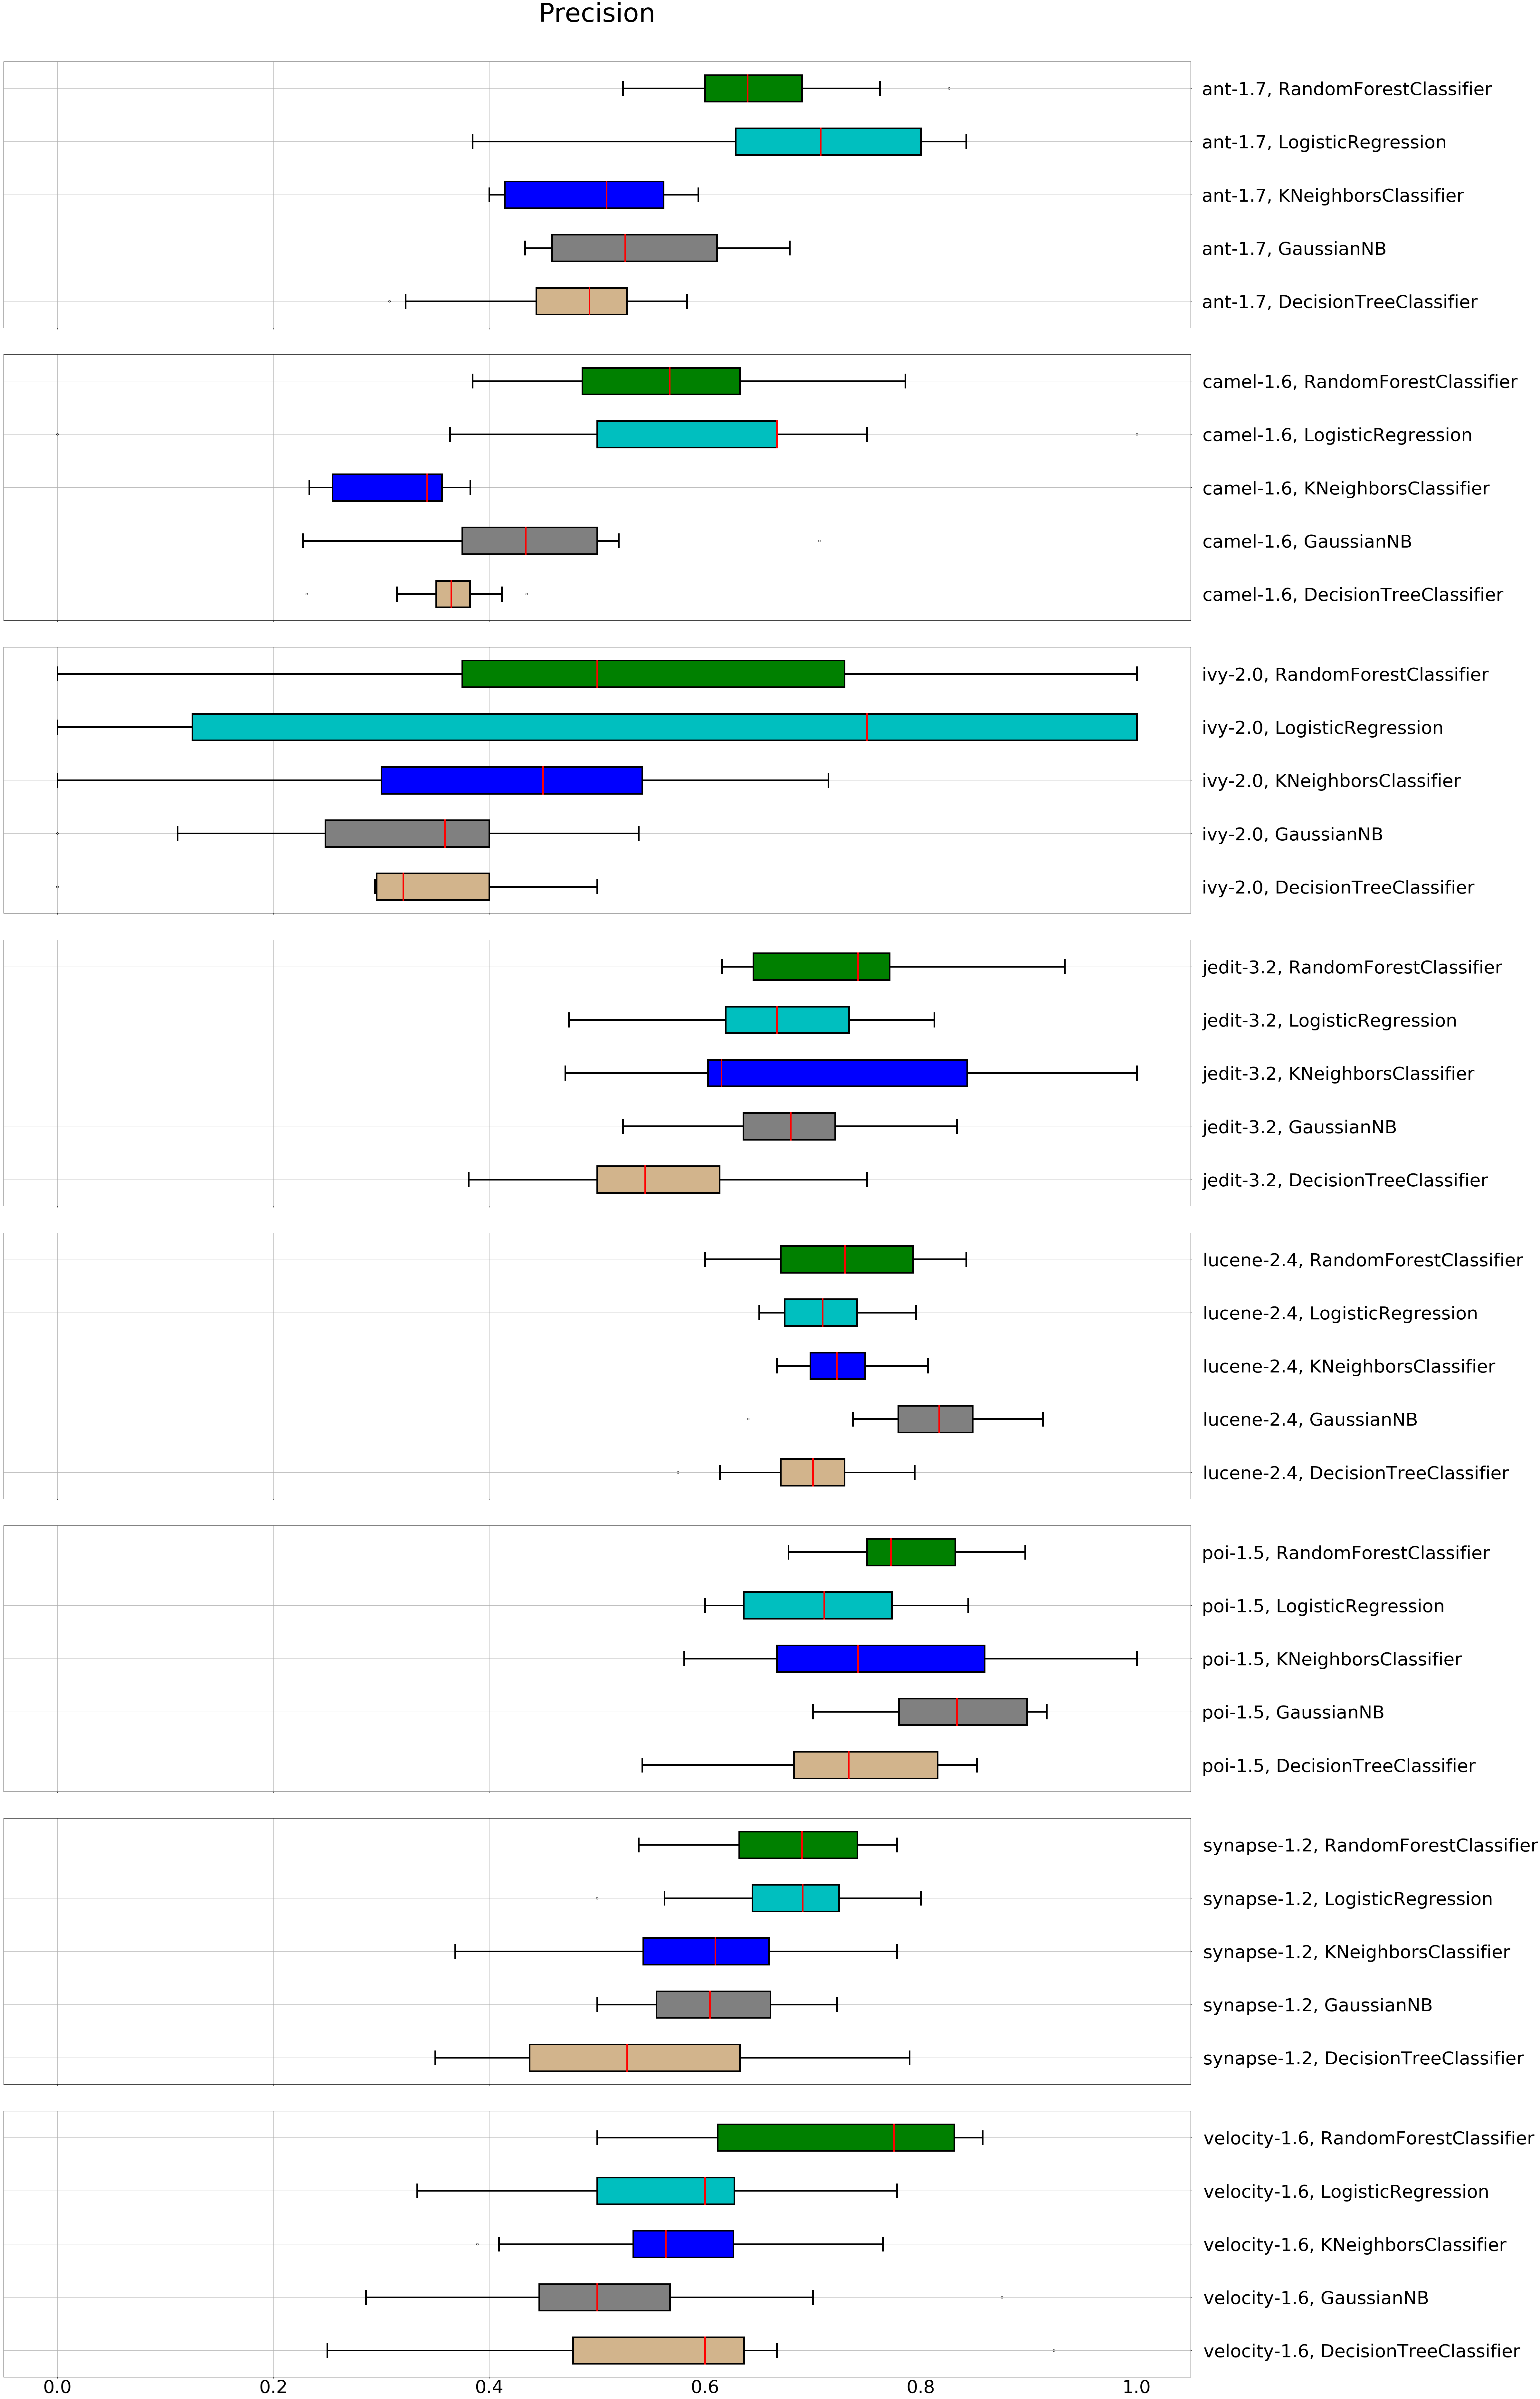

In [15]:
if PROCESS:
    plot_measure(df, "Precision", "wp-pm-p")
else:
    plot_measure(df, "Precision", "wp-p")    

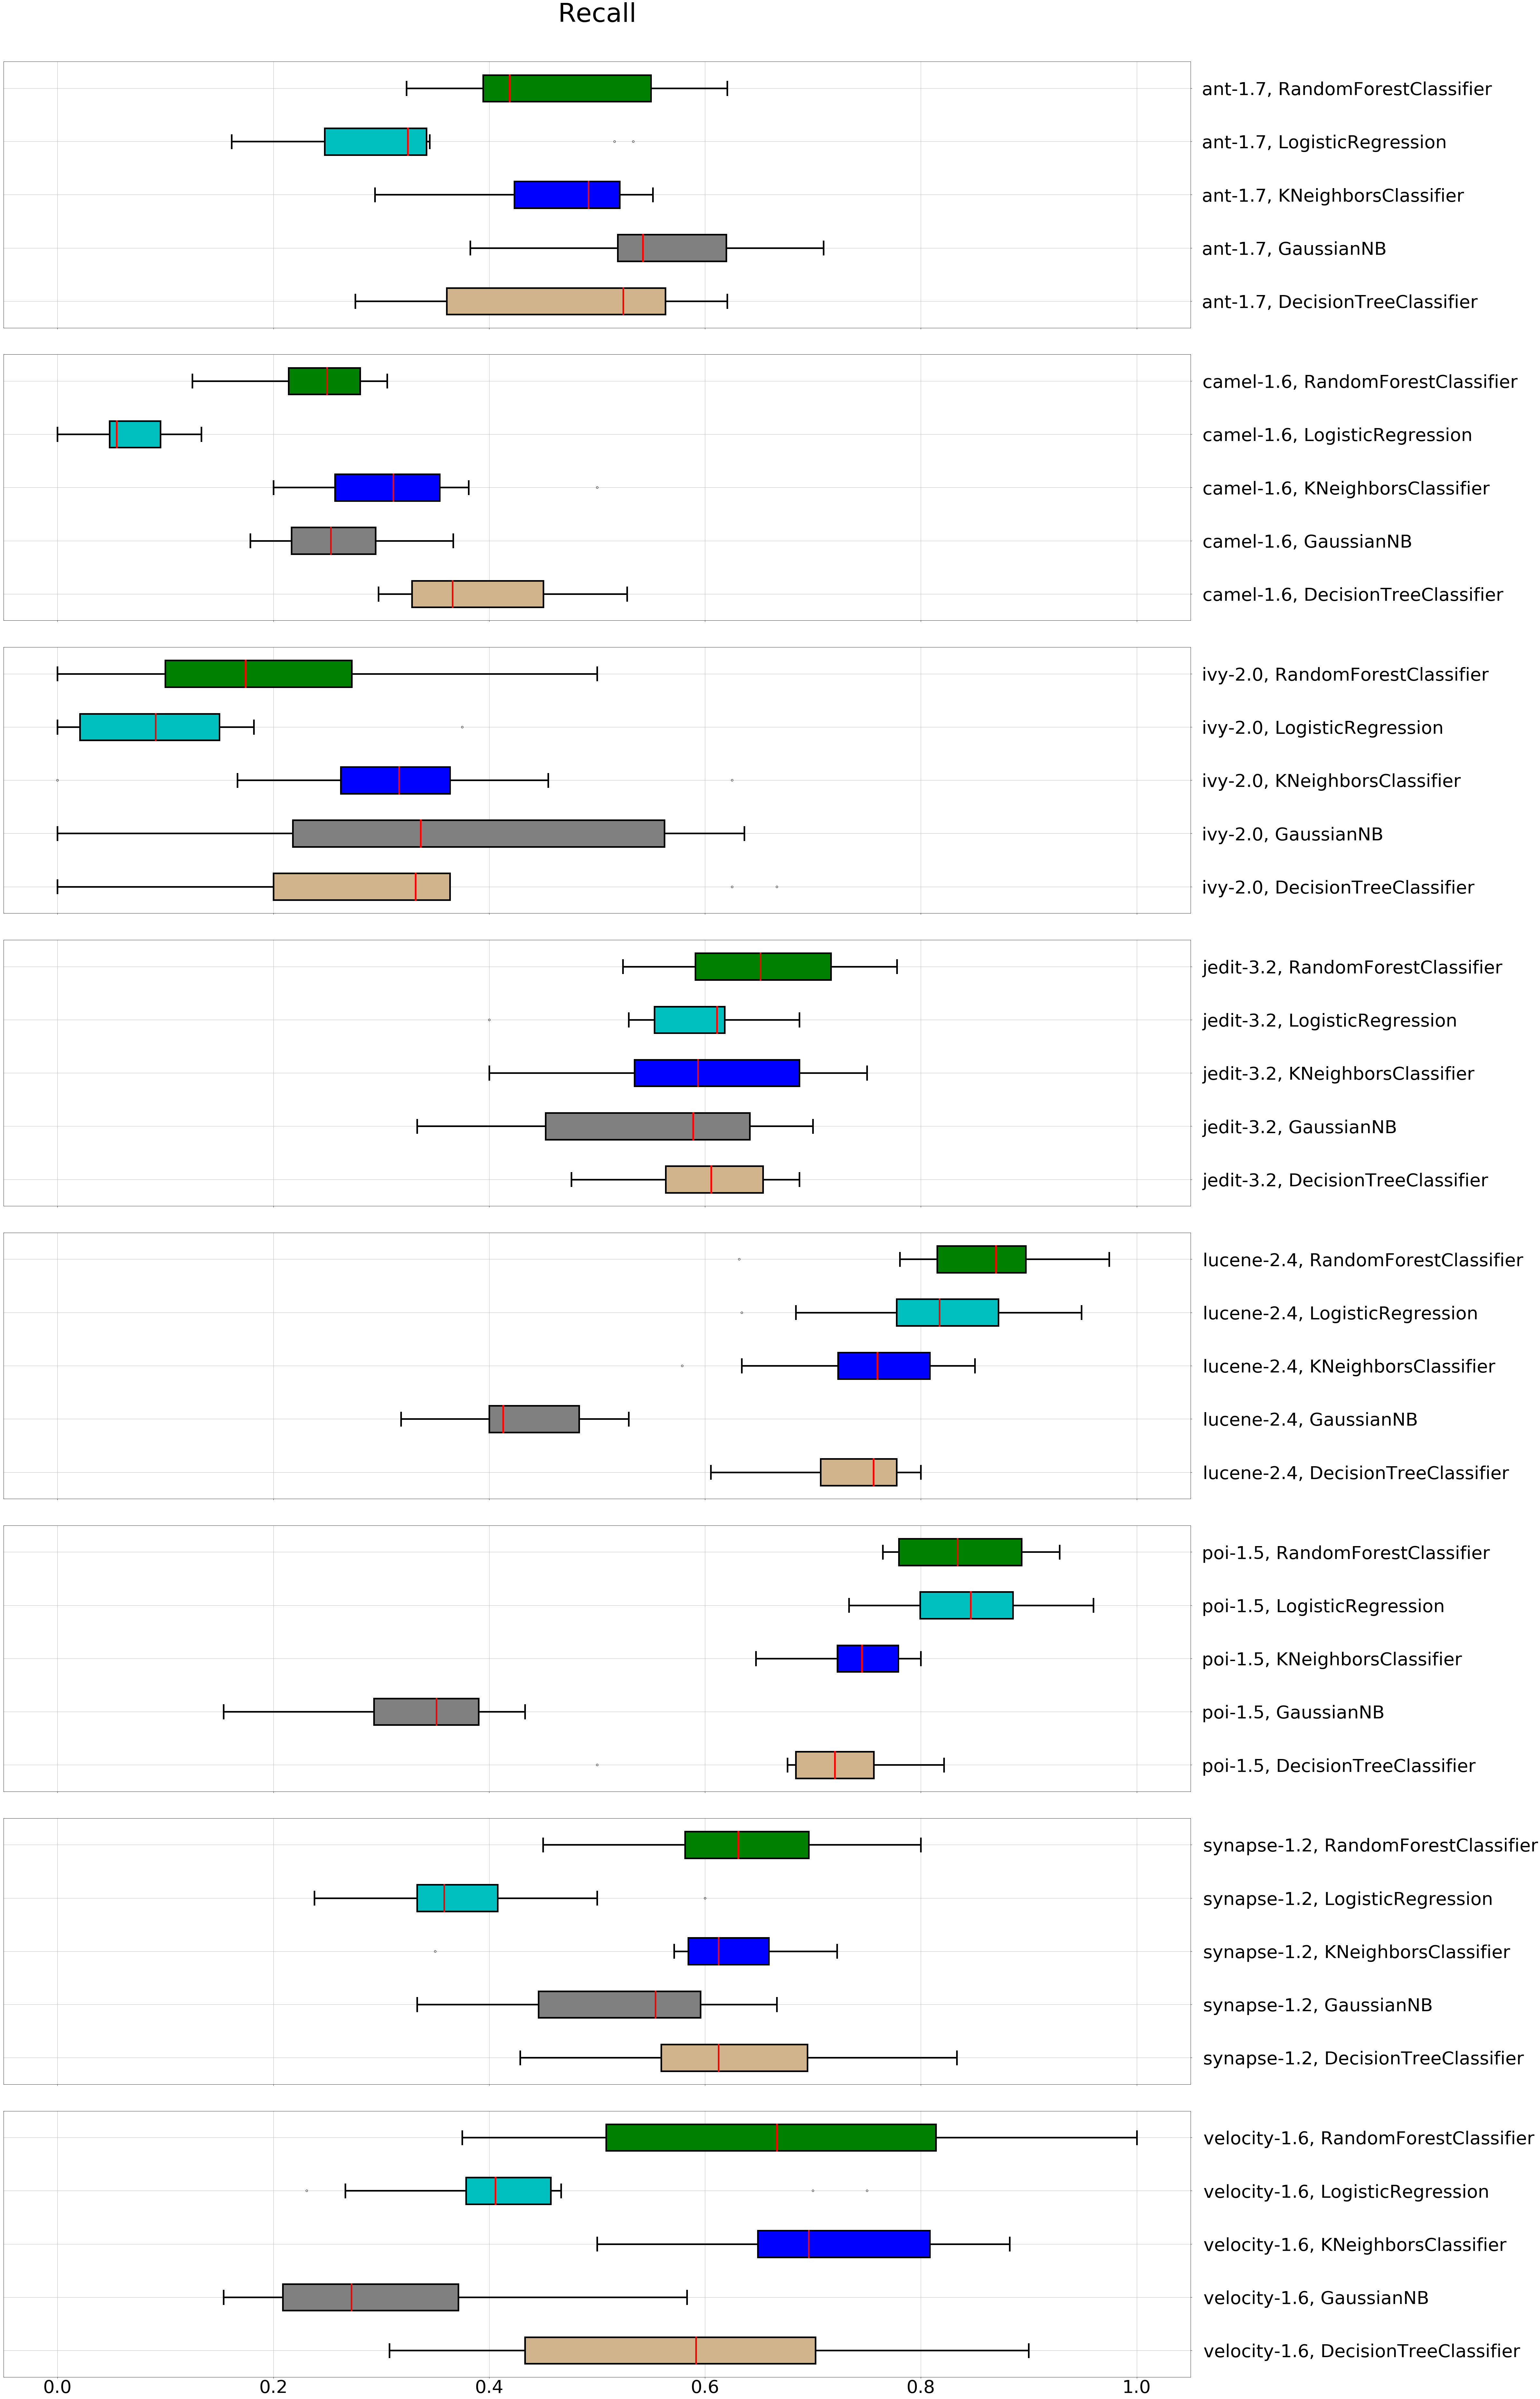

In [16]:
if PROCESS:
    plot_measure(df, "Recall", "wp-pm-r")
else:
    plot_measure(df, "Recall", "wp-r")